# Laboratorio: Analisi Flussi di Popolazione con pandas e matplotlib

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Proff. Gianluca Moro, Roberto Pasolini  
`nome.cognome@unibo.it`

In [1]:
# verifico che le librerie siano installate e ne stampo le versioni
import numpy
print("numpy", numpy.__version__)
import pandas
print("pandas", pandas.__version__)
import matplotlib
print("matplotlib", matplotlib.__version__)

numpy 1.23.5
pandas 1.5.3
matplotlib 3.7.0


## Caso di studio: Analisi flussi tra stati USA

L'ufficio del censimento degli Stati Uniti d'America pubblica annualmente un riepilogo dei flussi della popolazione tra stati

I dataset per ogni anno in formato XLS (Excel) possono essere reperiti alla pagina https://www.census.gov/data/tables/time-series/demo/geographic-mobility/state-to-state-migration.html

In questa esercitazione, lavoriamo sui dati dei flussi tra gli stati relativi al 2016

Eseguire la seguente cella per scaricare il file con i dati dell'esercitazione, se non presente

In [2]:
DATA_URL = "https://github.com/datascienceunibo/dialab2024/raw/main/Preprocessing_con_pandas/usa_census.npz"

import os.path
if not os.path.exists("usa_census.npz"):
    from urllib.request import urlretrieve
    urlretrieve(DATA_URL, "usa_census.npz")

### Caricamento dei dati

Abbiamo raccolto i dati da analizzare in un _archivio NumPy_, un file contenente un insieme di array con nomi associati: usiamo la funzione `load` di NumPy per caricarlo

In [3]:
import numpy as np
data = np.load("usa_census.npz")

L'oggetto `data` ottenuto è simile ad un dizionario, i cui valori sono le matrici e le cui chiavi sono i loro nomi

Otteniamo una lista dei nomi delle matrici caricate

In [4]:
print(", ".join(data.keys()))

states, population, area, same_house, same_state, other_state, state_to_state, from_abroad


### Dati disponibili

I dati contenuti nel file sono i seguenti:
- `states`: vettore con i nomi degli stati
- `population`: vettore con la popolazione totale attuale di ogni stato
- `area`: vettore con la superficie di terra di ciascuno stato in miglia quadrate
- `same_house`: vettore con numero di abitanti per stato che non hanno cambiato residenza nell'ultimo anno
- `same_state`: vettore con numero di abitanti per stato che hanno cambiato residenza nell'ultimo anno, ma non lo stato
- `other_state`: vettore con numero di abitanti per stato che si sono trasferiti da un altro stato nell'ultimo anno
- `state_to_state`: matrice col numero di abitanti trasferitisi nell'ultimo anno da ciascuno stato ad un altro
- `from_abroad`: vettore con numero di abitanti per stato trasferitisi negli USA dall'estero nell'ultimo anno

Possiamo stampare nome, tipo e forma di ciascun array

In [5]:
# modo semplice: passo i valori a print che li separa con uno spazio
for name, array in data.items():
    print(name, array.dtype, array.shape)

states <U20 (51,)
population int64 (51,)
area float64 (51,)
same_house int64 (51,)
same_state int64 (51,)
other_state int64 (51,)
state_to_state int64 (51, 51)
from_abroad int64 (51,)


In [6]:
# per maggiore leggibilità posso usare una f-string
for name, array in data.items():
    print(f"{name:>15}: {array.dtype!s:>8} {array.shape}")
    # "!s" = converti in stringa con str(x) in modo da poter applicare formato
    # ">N" = riserva N caratteri e allinea a destra

         states:     <U20 (51,)
     population:    int64 (51,)
           area:  float64 (51,)
     same_house:    int64 (51,)
     same_state:    int64 (51,)
    other_state:    int64 (51,)
 state_to_state:    int64 (51, 51)
    from_abroad:    int64 (51,)


Vediamo ad esempio l'array con i nomi degli stati, che sono in ordine alfabetico

In [7]:
data["states"]

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype='<U20')

In tutti i vettori, i dati relativi ad uno **stesso stato** si trovano nella **stessa posizione**

Ad esempio i dati relativi all'Alabama (`states[0]`) si trovano nella posizione 0 di ciascun array (`population[0]`, `area[0]`, ...)

Per comodità, importiamo gli array su cui lavoreremo come variabili locali

In [8]:
states = data["states"]
population = data["population"]
area = data["area"]

In [9]:
states[:5]

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California'],
      dtype='<U20')

### Esercizio 1: Ripasso NumPy

Usando sugli array `states` e `population` le operazioni viste nello scorso laboratorio, estrarre:

- **(1a)** il numero di abitanti del 5° stato in ordine alfabetico (California)
- **(1b)** i nomi degli ultimi tre stati in ordine alfabetico
- **(1c)** il numero di abitanti in Florida (senza sapere a priori la sua posizione)
- **(1d)** i nomi degli stati con almeno 20 milioni di abitanti
- **(1e)** il numero totale di abitanti in tutti gli stati
- **(1f)** il nome dello stato con meno abitanti

In [11]:
# 1a
population[4]

38783436

In [12]:
# 1b
states[-3:]

array(['West Virginia', 'Wisconsin', 'Wyoming'], dtype='<U20')

In [13]:
# 1c
population[states == "Florida"]

array([20401575])

In [14]:
# 1d
# promemoria: gli underscore "_" possono essere inseriti
# liberamente nei valori numerici per migliore leggibilità
states[population >= 20_000_000]

array(['California', 'Florida', 'Texas'], dtype='<U20')

In [15]:
# 1e
population.sum()

319361956

In [16]:
# 1f
states[population.argmin()]

'Wyoming'

## pandas

**pandas** è una libreria Python di uso comune per lavorare con dati in forma tabulare

pandas definisce le strutture dati _serie_ e _data frame_, simili agli array di NumPy ma dotate di _indici_ che etichettano i dati: questo rende semplice reperire dati specifici, ad esempio la popolazione di uno stato data l'etichetta (il nome)

Iniziamo importando il package `pandas` con l'alias convenzionale `pd`

In [17]:
import pandas as pd

## Serie

Una **_serie_** pandas è un vettore di valori simile ad un array 1D NumPy con un'etichetta associata a ciascuno

La sequenza di etichette costituisce l'_indice_ della serie, anch'esso un array 1D

Il costruttore `Series` permette di creare una serie di cui sono forniti i dati e l'indice (`index`) in due vettori di uguale lunghezza

Creiamo la serie `population` (sovrascrivendo l'array NumPy con lo stesso nome) con il numero di abitanti di ogni stato
- i dati della serie sono i numeri di abitanti contenuti nell'array `population`
- le etichette sono i nomi degli stati contenuti nell'array `states`

In [18]:
population = pd.Series(data["population"], index=data["states"])

- Visualizziamo la serie, utilizzando il metodo `head` per estrarne solo i primi N elementi

In [19]:
population.head(7)

Alabama         4810126
Alaska           731760
Arizona         6851836
Arkansas        2949650
California     38783436
Colorado        5476928
Connecticut     3541758
dtype: int64

- Sulla sinistra vediamo le **etichette** che formano l'indice: i nomi degli stati
- Sulla destra vediamo i **valori**: la popolazione di ciascuno stato
- In fondo vediamo il **tipo** (_dtype_) dei valori, in questo caso numeri interi

### Attributi di base di una serie

Una serie è composta dai dati e dalle etichette: gli attributi `values` e `index` restituiscono questi elementi in forma di vettori

In [20]:
population.values   [:5]

array([ 4810126,   731760,  6851836,  2949650, 38783436])

In [21]:
population.index    [:5]

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California'], dtype='object')

Il numero di valori si può ottenere con la funzione `len` di Python o (per analogia con gli array) con l'attributo `size`

In [22]:
len(population)
# oppure
population.size

51

### Selezionare dati da una serie

Le serie supportano in pratica le stesse tecniche di selezione degli array, ma usando le **etichette al posto degli indici numerici**

Per cui ad es. per ottenere la popolazione della California si scrive semplicemente:

In [23]:
population["California"]

38783436

Se si seleziona un'etichetta inesistente, si ha un `KeyError` come per i dizionari `{...}`

Si può selezionare un intervallo tra due etichette: in questo caso sono **inclusi entrambi gli estremi**, a differenza di altre strutture dati

In [24]:
population["Arizona":"Colorado"]

Arizona        6851836
Arkansas       2949650
California    38783436
Colorado       5476928
dtype: int64

Gli estremi dell'intervallo _A:B_ possono non esistere, vengono comunque presi gli elementi inclusi con _A <= etichetta <= B_ (funziona se le etichette sono in ordine)

Ad esempio per selezionare gli stati con iniziali da S a U (incluse) selezioniamo le etichette nell'intervallo `"S":"V"` (con `"S":"U"` verrebbe escluso "Utah" perché tale stringa è maggiore di "U")

In [25]:
population["S":"V"]

South Carolina     4903788
South Dakota        853832
Tennessee          6580953
Texas             27472626
Utah               3002244
dtype: int64

Si può selezionare un sottoinsieme della serie indicando una lista di etichette

In [26]:
# lista di stati della costa ovest
west_coast = ["Washington", "Oregon", "California"]

In [27]:
# popolazione stati della costa ovest
population[west_coast]

Washington     7202119
Oregon         4052221
California    38783436
dtype: int64

### Creazione delle altre serie

Creiamo una serie per altri vettori di dati, utilizzando sempre il vettore di nomi degli Stati `states` come indice

In [28]:
area        = pd.Series(data["area"],        index=data["states"])
other_state = pd.Series(data["other_state"], index=data["states"])
from_abroad = pd.Series(data["from_abroad"], index=data["states"])

### Operazioni tra serie

Come per gli array, è possibile effettuare operazioni elemento per elemento tra due serie o tra una serie ed un valore singolo

Si possono utilizzare operazioni binarie (`+`, `*`, ...) e funzioni universali di NumPy (`np.log`, ...)

Nel caso di due serie, le operazioni sono applicate **tra elementi di uguale etichetta** (indipendentemente dalla posizione!); la serie risultante avrà valori mancanti (NA) in corrispondenza di etichette presenti in un solo operando

- Ad es. per ottenere la popolazione in milioni di abitanti

In [29]:
(population / 1_000_000)    .head(3)

Alabama    4.810126
Alaska     0.731760
Arizona    6.851836
dtype: float64

- Per ottenere il logaritmo in base 10 della popolazione (ad es. per creare un grafico in tale scala):

In [30]:
np.log10(population)   .head(3)

Alabama    6.682156
Alaska     5.864369
Arizona    6.835807
dtype: float64

### Esercizio 2: Operazioni tra serie

- **(2a)** La serie `area` riporta la superficie degli stati in miglia quadrate: ricavare una serie `area_km2` con la superficie in chilometri quadrati (1 mi² = 2,59 km²)
- **(2b)** Creare una serie `density` con la densità di popolazione di ciascuno stato in abitanti per km²

In [33]:
# 2a
area_km2 = area * 2.59
# stampo i primi 3 elementi
area_km2.head(3)

Alabama    1.311714e+05
Alaska     1.477960e+06
Arizona    2.942087e+05
dtype: float64

In [35]:
# 2b
density = population / area_km2
# stampo i primi 3 elementi
density.head(3)

Alabama    36.670538
Alaska      0.495115
Arizona    23.289035
dtype: float64

### Serie booleane e selezione per condizioni

Usando operatori di confronto (`==`, `>`, ...) sulle serie, si ottiene una serie di valori booleani

Ad esempio, per ottenere la serie che associa `True` agli stati non più grandi di 5.000 miglia quadrate:

In [36]:
is_small = area <= 5000
is_small.head(10)

Alabama                 False
Alaska                  False
Arizona                 False
Arkansas                False
California              False
Colorado                False
Connecticut              True
Delaware                 True
District of Columbia     True
Florida                 False
dtype: bool

In modo simile agli array, una serie booleana può essere usata per selezionare in un'altra serie con stesse etichette solamente gli elementi a cui è associato `True`

Ad esempio, per mostrare la superficie dei soli stati piccoli individuati sopra:

In [37]:
area[area <= 5000]
# oppure: area[is_small]

Connecticut             4842.36
Delaware                1948.54
District of Columbia      61.05
Rhode Island            1033.81
dtype: float64

La serie da cui sono selezionati i dati e quella usata come condizione possono anche differire...

In [38]:
# popolazione degli stati piccoli
population[area <= 5000]

Connecticut             3541758
Delaware                 942073
District of Columbia     672022
Rhode Island            1045691
dtype: int64

Possiamo combinare serie booleane con gli operatori `&` (AND), `|` (OR), `^` (XOR), `~` (NOT)

**Attenzione:** tali operatori nel linguaggio Python hanno priorità superiore alle comparazioni (`>`, `<=`, ...), **usare le parentesi** per evitare errori

In [39]:
# popolazione degli stati piccoli con più di un milione di abitanti
population[   (area <= 5000) &    (population >= 1_000_000) ]

Connecticut     3541758
Rhode Island    1045691
dtype: int64

### Operazioni di riduzione sulle serie

Le serie offrono metodi simili a quelli degli array per aggregare i dati: `sum`, `mean`, `min`, `max`, ...

Ad esempio, per ottenere la popolazione totale di tutti gli stati:

In [40]:
population.sum()

319361956

Per ottenere la popolazione nello stato dove è maggiore:

In [41]:
population.max()

38783436

Per conoscere a quale Stato corrisponde, uso il metodo `idxmax` che restituisce l'etichetta del valore maggiore

In [42]:
population.idxmax()

'California'

Sono definiti analogamente `min` e `idxmin` per il valore minimo e la sua etichetta

In [43]:
population.min()

577567

In [44]:
population.idxmin()

'Wyoming'

Come in NumPy tali metodi si possono applicare anche alle serie booleane, con la tipica convenzione per cui `False` e `True` contano rispettivamente come 0 e 1

### Esercizio 3: Operazioni di riduzione su serie

Ricavare:
- **(3a)** il nome dello stato più piccolo
- **(3b)** la densità di popolazione dello stato più piccolo
- **(3c)** il numero di stati la cui popolazione è superiore al milione di abitanti
- **(3d)** il totale della popolazione degli stati sulla costa ovest (usare lista `west_coast` definita sopra)
- **(3e)** la densità media degli stati con almeno 10 milioni di abitanti

In [46]:
# 3a
area.idxmin()

'District of Columbia'

In [47]:
# 3b
density[area.idxmin()]

4250.089331170412

In [48]:
# 3c
(population > 1_000_000).sum()

44

In [49]:
# 3d
population[west_coast].sum()

50037776

In [50]:
# 3e
density[population >= 10_000_000].mean()

99.6921196099007

## DataFrame

Un `DataFrame` pandas contiene dati strutturati in **forma tabulare**, dove in genere

- **ogni riga** della tabella rappresenta **un elemento** dell'insieme che si sta analizzando (una persona, un territorio, ...)
- **ogni colonna** rappresenta **una caratteristica** di interesse (_feature_) degli elementi (età, popolazione, ...)

Le colonne di un data frame costituiscono un insieme di serie tutte con la stessa sequenza di etichette

- tale sequenza costituisce l'_indice delle righe_ del frame (o semplicemente _indice_)
- ogni colonna ha un nome, i nomi delle colonne formano l'_indice delle colonne_ del frame
- i datatype dei valori possono differire da una colonna all'altra

### Creare un DataFrame

Per creare un DataFrame possiamo passare un dizionario con una serie di valori per ciascuna colonna, la cui chiave è il nome

L'indice delle serie, identico per tutte, è usato come indice delle righe del DataFrame; se alcune etichette sono presenti solo in alcune serie, si ottengono valori mancanti nelle altre colonne

In [51]:
census = pd.DataFrame({
    "population": population,
    "from_abroad": from_abroad,
    "area": area_km2
})

Visualizziamo le prime righe del DataFrame come esempio...

In [52]:
census.head(5)

,population,from_abroad,area
Alabama,4810126,16062,1.311714e+05
Alaska,731760,6559,1.477960e+06
Arizona,6851836,53749,2.942087e+05
Arkansas,2949650,9051,1.347719e+05
California,38783436,336614,4.034682e+05


In alto sono scritti i nomi delle colonne, che costituiscono _l'indice delle colonne_

A sinistra sono scritti i nomi degli stati, che costituiscono _l'indice delle righe_

Gli indici **non** contano come righe o colonne del frame

Da un `DataFrame` possiamo estrarre i suoi componenti:

- la matrice dei dati `values`
- l'indice delle righe `index`
- l'indice delle colonne `columns`

In [53]:
census.values   [:4] # prime 4 righe

array([[4.81012600e+06, 1.60620000e+04, 1.31171405e+05],
       [7.31760000e+05, 6.55900000e+03, 1.47796006e+06],
       [6.85183600e+06, 5.37490000e+04, 2.94208667e+05],
       [2.94965000e+06, 9.05100000e+03, 1.34771893e+05]])

In [54]:
census.index   [:4] # primi 4 stati

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas'], dtype='object')

In [55]:
census.columns

Index(['population', 'from_abroad', 'area'], dtype='object')

Come per le matrici, possiamo ottenere il numero di righe e di colonne con `shape`

In [56]:
census.shape

(51, 3)

Un modo alternativo per creare un DataFrame è passare una matrice (array 2D) con i dati e vettori con nomi di righe e colonne

Ad esempio, possiamo convertire in DataFrame la matrice `state_to_state` che indica il numero di persone trasferitesi da uno stato all'altro nell'ultimo anno

Creiamo il DataFrame passando i dati nella matrice e usando il vettore dei nomi `states` come indice sia delle righe (`index`) che delle colonne (`columns`)

In [57]:
state_to_state = pd.DataFrame(data["state_to_state"], index=data["states"], columns=data["states"])

Abbiamo così convertito la matrice in una tabella leggibile, di cui quì visualizziamo una parte... _(essendoci un numero elevato di colonne, pandas mostra solo le prime 10 e ultime 10)_

In [58]:
state_to_state.head(5)

,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
Alabama,0,576,1022,495,6611,2177,566,0,97,16631,...,52,9960,7689,525,0,3535,677,42,874,539
Alaska,423,0,1176,65,3593,1401,0,79,0,1100,...,370,243,1675,725,86,462,4888,0,260,291
Arizona,894,1946,0,1205,64756,11895,1596,420,276,9306,...,2408,1834,14923,9979,817,8809,13897,1419,6736,925
Arkansas,2057,103,836,0,4026,3459,186,0,69,1351,...,0,2635,13487,619,0,1333,2257,75,539,178
California,3045,4206,33757,4282,0,22540,2932,1372,6319,25354,...,1333,6158,39109,11114,400,14348,27973,1150,7354,2674


Ogni riga rappresenta lo stato di destinazione, ogni colonna lo stato d'origine

Ad esempio, 423 persone si sono trasferite dall'Alabama all'Alaska

### Estrarre ed aggiungere colonne

Il DataFrame è utilizzabile come un dizionario i cui valori sono le colonne e le chiavi i loro nomi

Selezionando una chiave viene restituita la colonna con quel nome in forma di serie, l'indice della serie restituita è l'indice del DataFrame

In [59]:
census["population"]   .head(3)

Alabama    4810126
Alaska      731760
Arizona    6851836
Name: population, dtype: int64

Seguendo la stessa logica, è possibile aggiungere colonne assegnando una serie di valori ad un nome

- se una colonna col nome dato esiste già, viene sovrascritta
- se viene passata una serie, i valori sono assegnati per corrispondenza tra etichette e indice delle righe
- se viene passato un valore singolo (scalare), questo è replicato in tutte le righe

Questo permette di creare facilmente colonne con valori derivati dalle altre

Ad esempio, per aggiungere una colonna con la densità di popolazione _(senza usare la serie creata in precedenza)_:

In [60]:
census["density"] = census["population"] / census["area"]

La colonna viene così aggiunta come ultima nel DataFrame:

In [61]:
census.head(5)

,population,from_abroad,area,density
Alabama,4810126,16062,1.311714e+05,36.670538
Alaska,731760,6559,1.477960e+06,0.495115
Arizona,6851836,53749,2.942087e+05,23.289035
Arkansas,2949650,9051,1.347719e+05,21.886240
California,38783436,336614,4.034682e+05,96.125142


### Statistiche sui dati

Anche sui `DataFrame` sono disponibili i metodi `sum`, `mean`, `min`, ... per aggregare i dati

Di default, restituiscono una serie con la statistica calcolata **colonna per colonna**

In [62]:
# medie su tutti gli stati
census.mean()

population     6.261999e+06
from_abroad    4.307184e+04
area           1.793654e+05
density        1.585860e+02
dtype: float64

In [63]:
# somme su tutti gli stati
census.sum()

population     3.193620e+08
from_abroad    2.196664e+06
area           9.147635e+06
density        8.087884e+03
dtype: float64

Si noti che non sempre tutte le statistiche che si possono estrarre sono significative!

Ad esempio la somma ha senso sulla popolazione e sull'area, ma non sulla densità

Il metodo `describe` (applicabile anche alle serie) fornisce rapidamente un'insieme di statistiche sui valori di ciascuna colonna, utili ad analizzarne la distribuzione

In [64]:
census.describe()

,population,from_abroad,area,density
count,5.100000e+01,51.000000,5.100000e+01,51.000000
mean,6.261999e+06,43071.843137,1.793654e+05,158.585968
std,7.156688e+06,65074.514352,2.215125e+05,592.990817
min,5.775670e+05,2105.000000,1.581195e+02,0.495115
25%,1.737232e+06,8790.000000,8.633639e+04,18.459321
50%,4.385213e+06,19460.000000,1.388881e+05,40.722584
75%,7.026978e+06,52012.000000,2.089942e+05,86.390197
max,3.878344e+07,336614.000000,1.477960e+06,4250.089331


La tabella ottenuta mostra:
- `count` = valori non mancanti, ovvero diversi da NA
  - in questo caso non ci sono valori mancanti, quindi tutti i count sono pari al numero di righe (51)
- `mean` = media
  - ad es. la popolazione media per stato è di 6,26 milioni di abitanti
- `std` = deviazione standard
- `min`/`max` = valori minimo/massimo
- `25%`/`50%`/`75%` = percentili
  - ad es. il 25% degli stati ha densità di popolazione **inferiore a** 18,46 abitanti per km²

Di default le statistiche sono calcolate per colonne (riducendo le righe), perché è l'esigenza più comune: nella tabella `census`, così come in altri casi pratici, ogni colonna ha valori in scale diverse per cui non ha senso calcolare somma, media, ecc. per riga

`sum()` in un DataFrame corrisponde in pratica a `sum(0)` in una matrice NumPy

Nel caso si vogliano calcolare le statistiche per righe (riducendo le colonne), si può specificare `axis=1`: questo corrisponde in pratica a `sum(1)` su una matrice NumPy

Ad esempio, applicando `sum()` in modo standard al DataFrame `state_to_state`, otteniamo il totale di abitanti trasferitisi **da** ogni stato (colonne)...

In [65]:
state_to_state.sum()   .head(3)

Alabama     99892
Alaska      42074
Arizona    192103
dtype: int64

...mentre applicando `sum(axis=1)` o in breve `sum(1)` otteniamo il totale di abitanti trasferitisi **verso** ogni stato (righe)...

In [66]:
state_to_state.sum(axis=1)   .head(3)

Alabama    122220
Alaska      31300
Arizona    273257
dtype: int64

...che è esattamente quanto riportato nella serie `other_state`: possiamo verificarlo col metodo `equals` che indica se due serie sono identiche

In [67]:
state_to_state.sum(axis=1).equals(other_state)

True

### Esercizio 4: Operazioni sui DataFrame

Utilizzando i frame `census` e `state_to_state` (senza utilizzare le serie usate in precedenza), ricavare

- **(4a)** la superficie dello stato più grande
- **(4b)** il numero totale di persone emigrate dall'Arizona ad un altro stato
- **(4c)** il nome dello stato verso cui sono immigrate meno persone dagli altri stati
  - promemoria per `state_to_state`: colonna = stato di origine, riga = stato di destinazione

In [69]:
# 4a
census["area"].max()

1477960.0605

In [70]:
# 4b
state_to_state["Arizona"].sum()

192103

In [71]:
# 4c
state_to_state.sum(axis=1).idxmin()

'Vermont'

### Selezione

Per selezionare una porzione arbitraria di DataFrame, vanno indicate righe e colonne da includere

Esistono diversi _selettori_, che consentono di selezionare parti di un DataFrame `X` in modo diverso:
- `X.loc[...]` seleziona righe e colonne specificate **per etichetta** (es.: colonna "population")
- `X.iloc[...]` seleziona righe e colonne specificate **per posizione** (es.: colonna 0)

In entrambi i casi tra le parentesi vanno specificate righe e colonne da selezionare, come avviene nelle matrici
- si può selezionare per valore singolo, intervallo, lista di valori o serie booleana con stesso indice
- `:` indica di selezionare tutte le righe o le colonne, se usato per le colonne può essere omesso

Ad esempio per selezionare facilmente solo le prime righe e colonne di un DataFrame posso usare `iloc` per specificare gli intervalli per posizione:

In [72]:
state_to_state.iloc[:3, :5]  # forma breve per [0:3, 0:5]

,Alabama,Alaska,Arizona,Arkansas,California
Alabama,0,576,1022,495,6611
Alaska,423,0,1176,65,3593
Arizona,894,1946,0,1205,64756


Selezionando una **singola riga** di un DataFrame, **otteniamo una serie** con i valori di tutte le colonne

In [73]:
census.loc["California", :]   # ", :" può essere omesso

population     3.878344e+07
from_abroad    3.366140e+05
area           4.034682e+05
density        9.612514e+01
Name: California, dtype: float64

Usando serie booleane, possiamo selezionare righe (o colonne) per condizioni

In [74]:
# righe relative agli Stati con meno di 700.000 abitanti
census.loc[census["population"] < 700000]

,population,from_abroad,area,density
District of Columbia,672022,11155,158.1195,4250.089331
Vermont,619387,2113,23871.1494,25.947096
Wyoming,577567,2105,251471.2326,2.296752


In [75]:
# densità di popolazione degli Stati con superficie minore di 10.000 km²
census.loc[census["area"] < 10000, "density"]

Delaware                 186.670404
District of Columbia    4250.089331
Rhode Island             390.537622
Name: density, dtype: float64

Per selezionare righe per posizione e colonne per etichetta (o viceversa), si possono concatenare le applicazioni di `loc` e `iloc`

In [76]:
# prime tre righe, colonna "population"
census.iloc[:3].loc[:, "population"]

Alabama    4810126
Alaska      731760
Arizona    6851836
Name: population, dtype: int64

`loc` e `iloc` si possono usare con la stessa logica anche sulle serie, selezionando su una sola dimensione invece di due (`loc` equivale alla selezione normale per etichette)

In [77]:
# valori di population dal 6° al 10°
population.iloc[5:10]

Colorado                 5476928
Connecticut              3541758
Delaware                  942073
District of Columbia      672022
Florida                 20401575
dtype: int64

### Ordinamento

Sia serie che DataFrame forniscono metodi per cambiare l'ordinamento dei dati

La funzione `sort_index` ordina una serie o le righe di un frame secondo le etichette (nel nostro caso le righe sono già ordinate alfabeticamente per etichetta)

`sort_values` invece ordina una serie secondo i valori in essa o le righe di un frame secondo i valori di una colonna specificata per nome; è possibile specificare una lista di più colonne per risolvere i pareggi, come nella clausola `ORDER BY` di SQL

In entrambi i metodi possiamo specificare:

- `axis=1` (se applicato ad un frame) per cambiare l'ordinamento delle colonne invece delle righe
- `ascending=False` per applicare un ordinamento decrescente

Possiamo ad esempio per visualizzare i 5 Stati più popolati

In [78]:
census.sort_values("population", ascending=False).head(5)

,population,from_abroad,area,density
California,38783436,336614,403468.1798,96.125142
Texas,27472626,234749,676590.1289,40.604533
Florida,20401575,232838,138888.1284,146.892144
New York,19526443,166069,122057.3760,159.977575
Illinois,12654142,65886,143794.0287,88.001860


Sia questi metodi che altri che vedremo per trasformare serie o DataFrame **restistuiscono un nuovo oggetto** senza modificare quello esistente.

Ad esempio in questo caso il frame `census` non è stato modificato, bensì è stato creato un nuovo frame che è stato restituito da `sort_values` per essere visualizzato.

È comune in pandas applicare trasformazioni composte di più passaggi concatenando chiamate a diversi metodi, come in questo caso, in cui a `sort_values` è seguito `head`.

_In questi e in altri metodi che vedremo è possibile specificare `inplace=True` per modificare l'oggetto esistente invece di restituirne un altro. Questo però è generalmente sconsigliato, specialmente lavorando in Jupyter o simili, per mantenere il codice più facilmente interpretabile._

### Esercizio 5: Selezione da DataFrame

Utilizzando il frame `census` (senza utilizzare le serie usate in precedenza), ricavare

- **(5a)** la superficie della California
- **(5b)** la popolazione (colonna 0) del 13° stato nella tabella
- **(5c)** la densità di popolazione dello stato con superficie maggiore
- **(5d)** la popolazione totale degli stati con nome che inizia per M
- **(5e)** la superficie complessiva degli stati con almeno 20 milioni di abitanti
- **(5f)** la popolazione media degli stati con almeno l'1% di popolazione immigrato dall'estero (`from_abroad`) nell'ultimo anno
- **(5g)** la superficie totale dei 5 stati con densità di popolazione minore
- **(5h)** la popolazione (colonna 0) del 3° stato con superficie maggiore

In [80]:
# 5a
census.loc["California", "area"]

403468.1798

In [81]:
# 5b
census.iloc[12, 0]

1663756

In [82]:
# 5c
census.loc[census["area"].idxmin(), "density"]

4250.089331170412

In [83]:
# 5d
census.loc["M":"N", "population"].sum()

39290015

In [84]:
# 5e
census.loc[census["population"] >= 20_000_000, "area"].sum()

1218946.4370999997

In [85]:
# 5f
census.loc[census["from_abroad"] / census["population"] >= 0.01, "population"].mean()

7307324.0

In [86]:
# 5g
census.sort_values("density").head(5)["area"].mean()

496291.49541999993

In [87]:
# 5h
census.sort_values("area", ascending=False).iloc[2, 0]

38783436

## Creazione di grafici con matplotlib 

I grafici sono in generale utili nell'analisi preliminare di dati per visualizzare come sono distribuiti i valori in una serie di dati

**matplotlib** è tra le librerie Python più diffuse per la creazione di svariati tipi di grafici (a barre, a torta, a dispersione, ...)

Iniziamo in questo laboratorio a vedere come creare alcune tipologie di grafici, vedremo nel prossimo altri tipi di grafici e opzioni più avanzate

Vediamo due approcci alternativi per creare dei grafici con matplotlib

- invocando direttamente le funzioni dell'interfaccia semplificata `pyplot` (che riprende quella di Matlab), a cui vanno esplicitamente passati i dati da graficare
- utilizzando i metodi `plot.*` forniti da pandas per creare rapidamente grafici dai dati contenuti in serie e DataFrame

Per iniziare, importiamo l'interfaccia `pyplot` con l'alias convenzionale `plt`

In [88]:
import matplotlib.pyplot as plt

È inoltre comune eseguire il seguente comando per assicurarsi che i grafici siano disegnati all'interno dei file Jupyter (necessario in versioni più vecchie di Jupyter)

In [89]:
%matplotlib inline

### Grafici a barre

Un grafico a barre raffigura una serie di valori come barre di diversa altezza, consentendone un confronto rapido

Si crea con la funzione `bar`, indicando in ordine le etichette da assegnare alle barre e i rispettivi valori da usare come altezze

I dati possono essere passati in qualsiasi oggetto _array-like_ (liste, array NumPy, serie pandas, ...)

<BarContainer object of 4 artists>

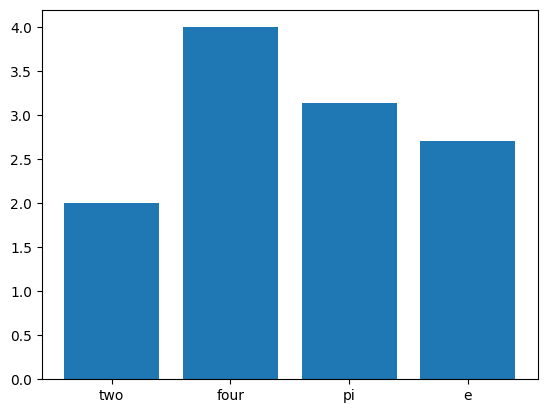

In [90]:
plt.bar(
    [ "two", "four",   "pi",    "e"],  # etichette
    [     2,      4,   3.14,   2.71]   # valori
)

Possiamo utilizzarli ad esempio per visualizzare i valori di una serie

Prendiamo come esempio la popolazione dei paesi della costa ovest

Essendo numeri molto grandi, matplotlib li visualizza in notazione scientifica ("1e7" = decine di milioni)

In [91]:
west_coast_population = population[west_coast]
west_coast_population

Washington     7202119
Oregon         4052221
California    38783436
dtype: int64

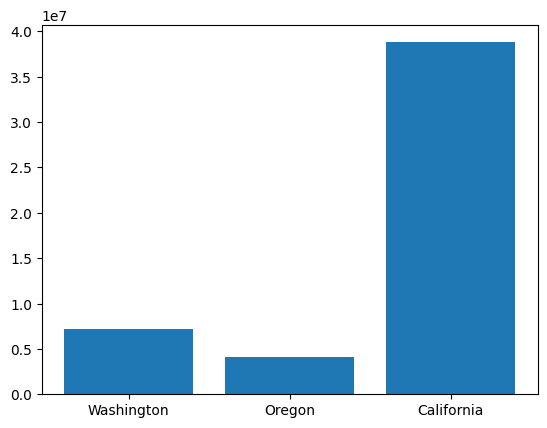

In [92]:
plt.bar(
    west_coast_population.index,  # etichette
    west_coast_population.values  # valori
);  # <-- aggiungere ";" alla fine per non visualizzare l'output testuale "<...>"

Come alternativa più semplice, si può usare il metodo `plot.bar` disponibile sulle strutture dati pandas, che crea un grafico

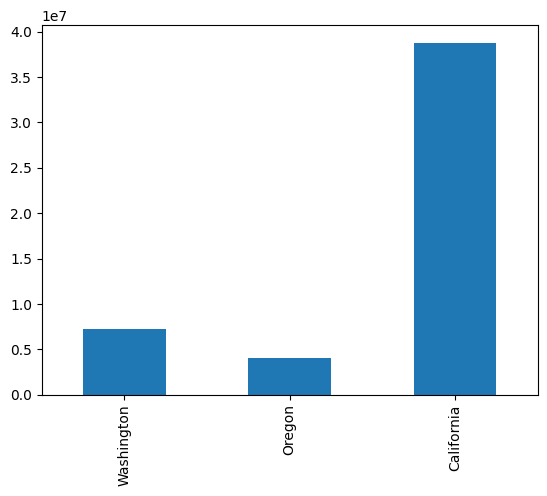

In [93]:
west_coast_population.plot.bar();

Nei grafici successivi visualizziamo la popolazione di tutti i 51 stati in milioni di abitanti (dividiamo tutti i valori per 1.000.000), in modo da leggere più facilmente l'asse y

In [94]:
population_mln = population / 1_000_000

Tramite la funzione `figure` è possibile configurare alcune opzioni del grafico costruito con le istruzioni successive nella medesima cella di codice

In particolare possiamo regolare le dimensioni del grafico `figsize` in forma di tupla `(larghezza, altezza)`

Utilizziamola creare un grafico più largo con la popolazione di tutti gli stati

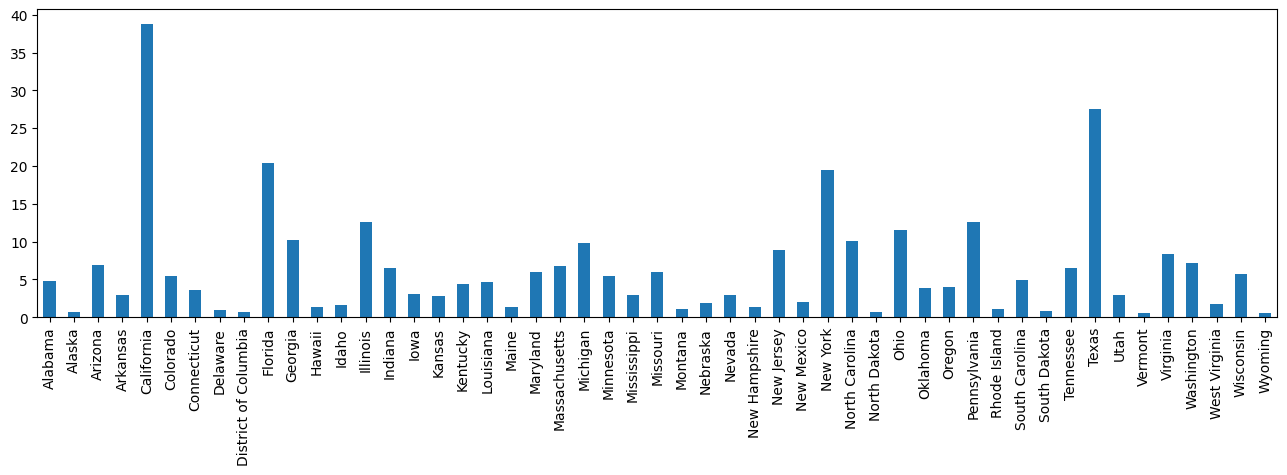

In [95]:
plt.figure(figsize=(16, 4))
population_mln.plot.bar();

L'opzione `figsize` può anche essere passata direttamente ai metodi `plot.*` di pandas

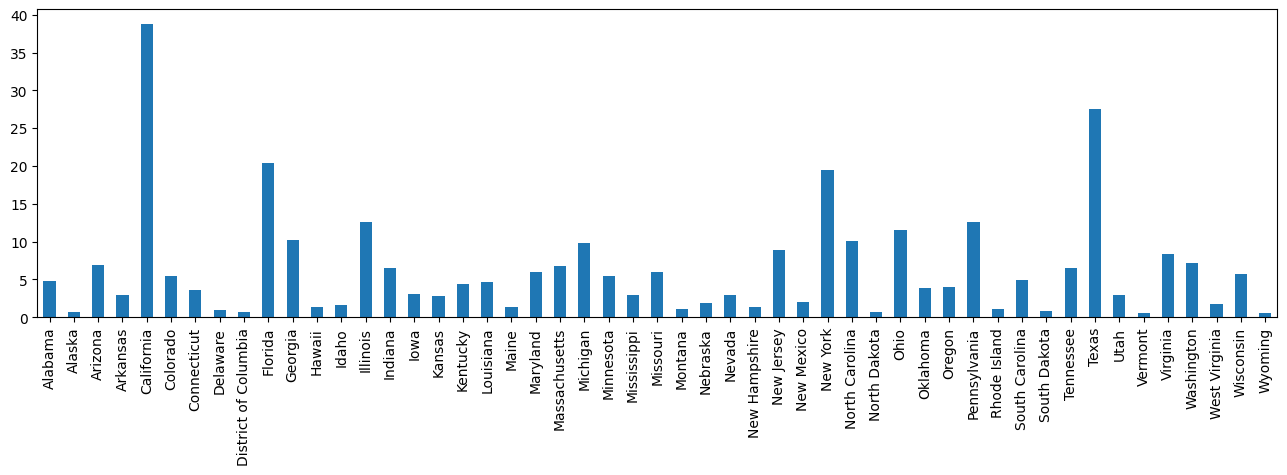

In [96]:
population_mln.plot.bar(figsize=(16, 4));

Con la funzione `grid` è possibile aggiungere al grafico una griglia su entrambi gli assi o su un solo asse ("x" o "y") indicato

_(per aggiungerla ad entrambi gli assi usare `plt.grid()` oppure specificare `grid=True` in `plot.bar`)_

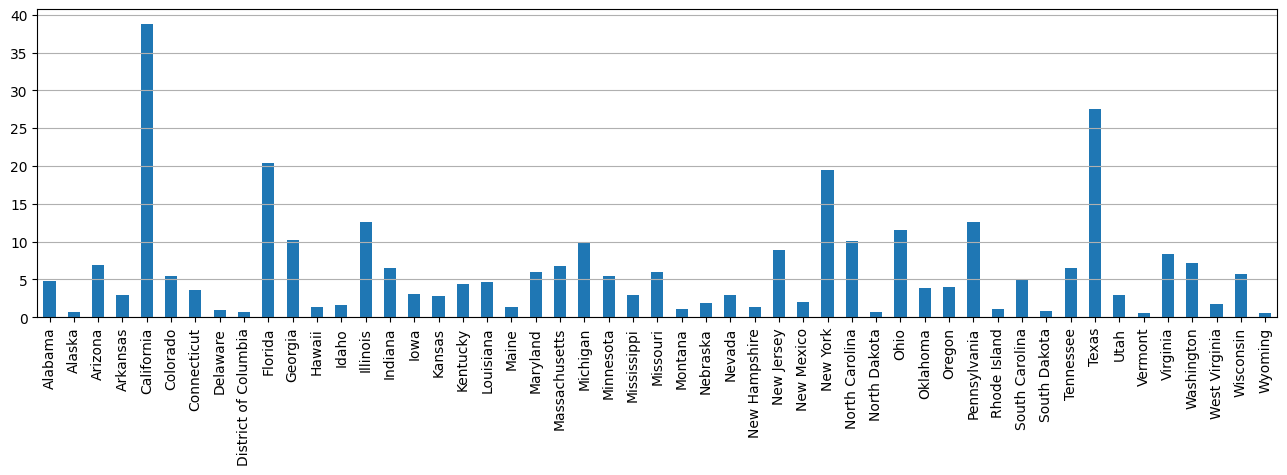

In [97]:
population_mln.plot.bar(figsize=(16, 4));
plt.grid(axis="y");

Con le funzioni `title`, `xlabel` e `ylabel` è possibile specificare un titolo del grafico, un'etichetta per l'asse X e una per l'asse Y

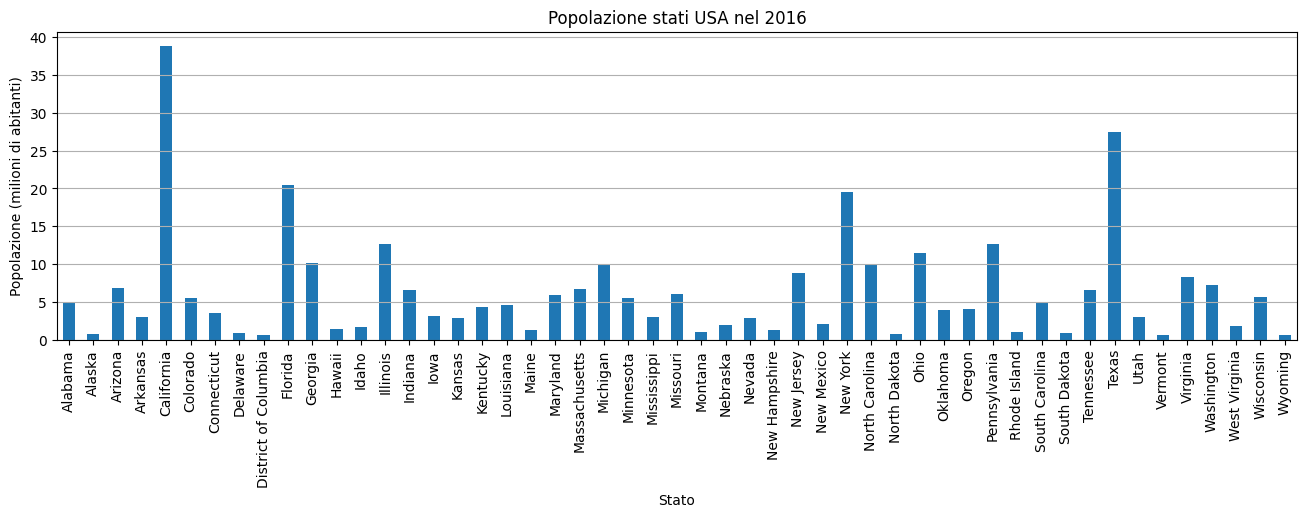

In [98]:
population_mln.plot.bar(figsize=(16, 4))
plt.grid(axis="y")
plt.title("Popolazione stati USA nel 2016")
plt.xlabel("Stato")
plt.ylabel("Popolazione (milioni di abitanti)");

### Box plot

Un _box plot_ visualizza in modo compatto le statistiche di base di una o più serie di dati

In pratica fornisce visivamente molte delle informazioni restituite dal metodo `describe` visto sopra

Vediamolo ad esempio sulla popolazione degli stati usando la funzione `boxplot`...

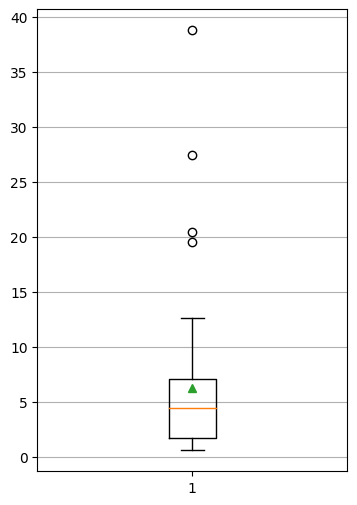

In [99]:
plt.figure(figsize=(4, 6))
plt.boxplot(population_mln, showmeans=True)
plt.grid(axis="y");

...o alternativamente il metodo `plot.box`

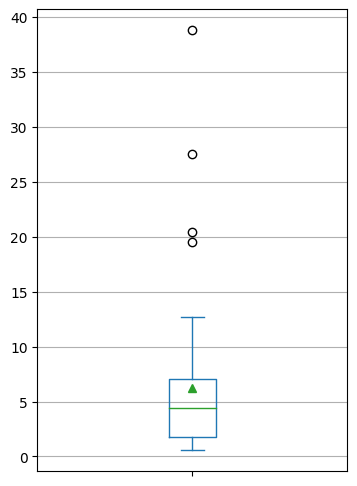

In [100]:
population_mln.plot.box(showmeans=True, figsize=(4, 6))
plt.grid(axis="y");

Il grafico contiene i seguenti componenti

- Gli estremi inferiore e superiore del rettangolo (circa 2 e 7 milioni di abitanti) sono il **primo e terzo quartile** ($Q_1$ e $Q_3$) dei dati, visualizzati come "25%" e "75%" nell'output di `describe`
  - il rettangolo rappresenta in pratica il 50% "centrale" dei valori
  - la distanza dal primo al terzo quartile ($Q_3-Q_1$) è detta _interquartile range_ (IQR)
- La linea centrale (circa 4 milioni) indica la **mediana**, ovvero il secondo quartile ("50%" in `describe`)
- I cerchi rappresentano i valori molto distanti dalla mediana, detti **outlier**
  - nello specifico, sono outlier tutti i valori che sono distanti dal quartile più vicino più di 1,5 volte l'IQR
  - formalmente, un valore $x$ è outlier se $x < Q_1 - 1.5\cdot{IQR}$ oppure $x > Q_3 + 1.5\cdot{IQR}$
  - 1,5 è un valore usato convenzionalmente, che può essere cambiato col parametro `whis` di `boxplot`/`box`
- I "baffi" (_whiskers_) indicano i valori **minimo** e **massimo** dei dati, escludendo gli outlier
- Il triangolo (circa 6 milioni) indica la **media**, che viene omessa se non si specifica `showmeans=True`

Si riporta sotto l'output di `describe` sulla medesima serie, da cui ritornano i valori evidenziati nel box plot

In [101]:
population_mln.describe()

count    51.000000
mean      6.261999
std       7.156688
min       0.577567
25%       1.737232
50%       4.385213
75%       7.026977
max      38.783436
dtype: float64

Dagli outlier nella parte superiore e dalla media superiore alla mediana, si intuisce ad occhio che la serie `population` ha pochi valori molto superiori alla mediana

Per confronto, si osservi sotto il box plot di un array di 1.000 valori casuali con distribuzione normale: il grafico tende ad essere simmetrico (media = mediana, pochi outlier distribuiti equamente)

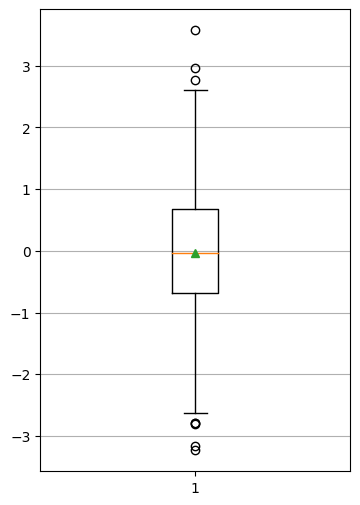

In [102]:
np.random.seed(123)
random_values = np.random.normal(size=1000)
plt.figure(figsize=(4, 6))
plt.boxplot(random_values, showmeans=True)
plt.grid(axis="y");

Invocando `plot.box` su un DataFrame viene generato un grafico unico con i box plot di tutte le colonne numeriche

Notare che un grafico con più variabili può essere difficilmente leggibile se le scale di valori sono molto diverse, come in questo caso

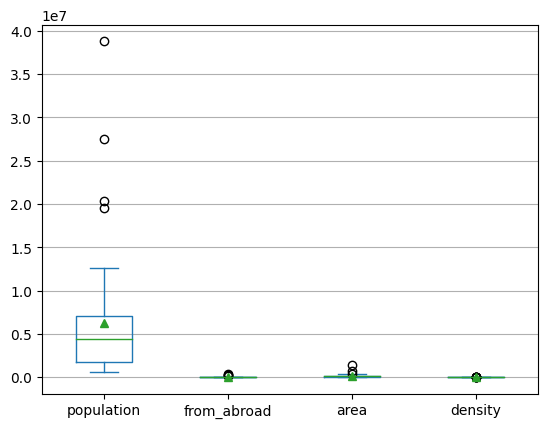

In [103]:
census.plot.box(showmeans=True)
plt.grid(axis="y");

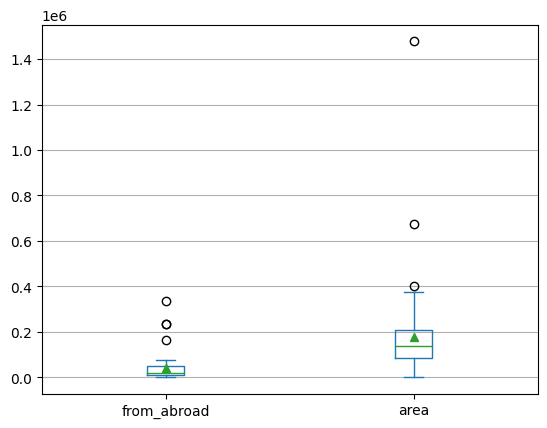

In [104]:
# grafico solo su due colonne, parzialmente più leggibile
census[["from_abroad", "area"]].plot.box(showmeans=True)
plt.grid(axis="y");

### Esercizio 6: Creazione di grafici

- **(6a)** Visualizzare un diagramma a barre con la densità di popolazione degli stati, ordinandoli per densità decrescente
- **(6b)** Visualizzare in un boxplot la distribuzione della popolazione dei soli stati con superficie superiore a 100.000 mi²

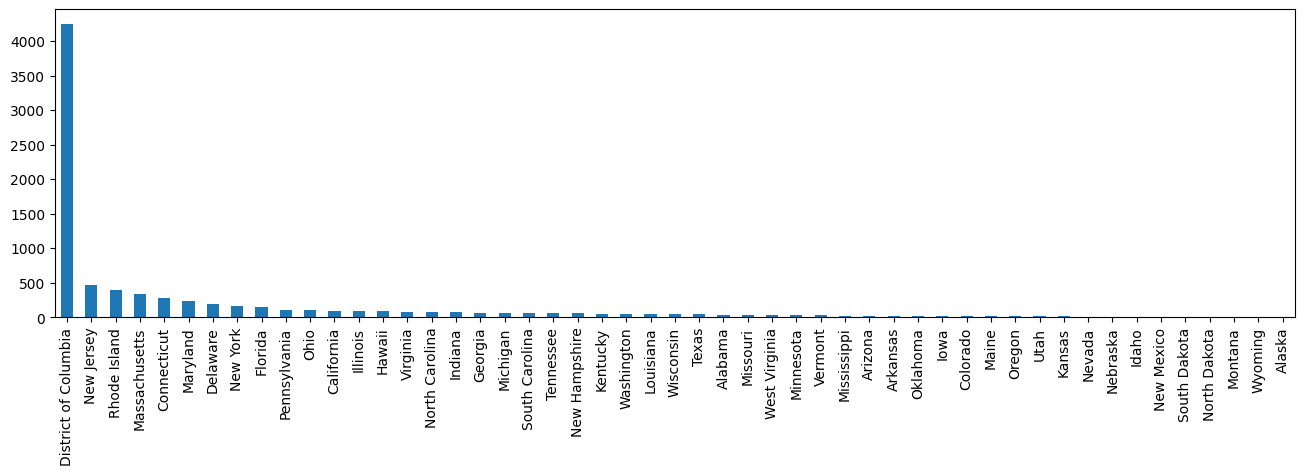

In [106]:
# 6a
census["density"].sort_values(ascending=False).plot.bar(figsize=(16, 4));

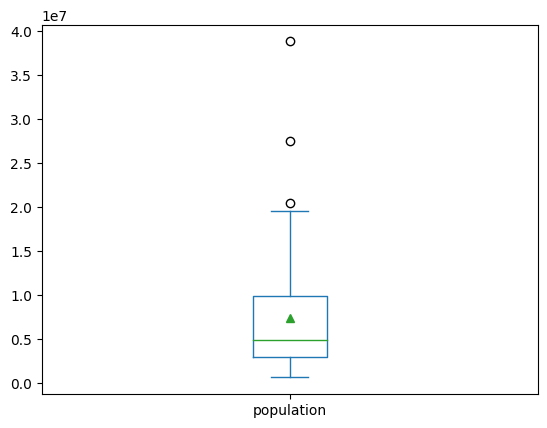

In [107]:
# 6b
census.loc[census["area"] > 100_000, "population"].plot.box(showmeans=True);